In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import h5py
from collections import OrderedDict
from importlib import reload

%matplotlib notebook

In [2]:
import qcodes as qc

# Setup notes

For this example to run, you need to have set up a labpython config file. There is a template in labpythonQDelft/templates.

In [3]:
import labpythonconfig as cfg
reload(cfg)

from importlib import reload
from stationq.qctools import instruments as instools
reload(instools)

from stationq.data import data_storage
reload(data_storage)
from stationq.data.data_storage import Data, GridData

from stationq.experiment import measurement
reload(measurement)
from stationq.experiment.measurement import Parameter, BaseMeasurement, PysweepGrid

In [6]:
from pysweep.data_storage import base_storage
reload(base_storage)
from pysweep.data_storage.base_storage import BaseStorage, DataSet

from pysweep import sweep_object
reload(sweep_object)
from pysweep.sweep_object import BaseSweepObject, sweep, ChainSweep

In [4]:
station = qc.Station()

In [5]:
class NameSpace:
    pass

namespace = NameSpace()

In [7]:
class DummyMeasurement(BaseMeasurement):
    def __init__(self, station, namespace):
        super().__init__(station, namespace)
        
        self.add_parameter('start', Parameter)
        self.add_parameter('stop', Parameter)
        self.add_parameter('npts', Parameter)
    
    def measure(self):        
        # set up loop
        xpoints = np.linspace(self.start(), self.stop(), self.npts())
        ypoints = np.linspace(self.start(), self.stop(), self.npts())
                
        # now populate in a primitive loop
        for x in xpoints:
            for y in ypoints:
                
                # acquire some data
                z = np.cos(x) * np.cos(y) * np.linspace(0,1,3)

                # add to dataset
                self.data.add(OrderedDict(
                        {'idx' : {'value' : np.arange(z.size).reshape(z.shape), 'independent_parameter' : True, },
                         'y' : {'value' : y, 'independent_parameter' : True, 'unit' : 'V'},
                         'x' : {'value' : x, 'independent_parameter' : True, 'unit' : 'V'},
                         'z' : {'value' : z },
                        }
                ))
                    

m = DummyMeasurement(station, namespace)
m.start(0)
m.stop(10)
m.npts(3)
m.run()

In [8]:
voltage1 = 0
voltage2 = 0

def getv1():
    global voltage1
    return voltage1

def setv1(v):
    global voltage1
    voltage1 = v

def getv2():
    global voltage2
    return voltage2

def setv2(v):
    global voltage2
    voltage2 = v

v1 = qc.Parameter('voltage1', get_cmd=getv1, set_cmd=setv1, unit='V')
v2 = qc.Parameter('voltage2', get_cmd=getv2, set_cmd=setv2)

station = qc.Station(v1, v2)

In [9]:
class SimpleGrid(PysweepGrid):
    
    def measure_datapoint(self, station, namespace):
        scale = np.linspace(0,1,3)
        return OrderedDict({
            'scale' : {'value' : scale, 'independent_parameter' : True, },
            'data' : {'value' : (self.station.voltage1() + self.station.voltage2()**2) * scale},
        })
    
    def sweep(self):
        return
    
    
m = SimpleGrid(station, namespace)
m.sweep = [
    (m.station.voltage1, np.linspace(0,1,3)),
    (m.station.voltage2, np.linspace(0,2,5)),
]
m.run()

In [7]:
GridData.export_spyview = True

In [23]:
class InnerSweepOnly(BaseMeasurement):
    data_cls = GridData
    
    def measure(self):
        xs = np.linspace(0, 10, 101)
        ys = np.linspace(0, 9, 91)
        
        xx, yy = np.meshgrid(xs, ys, indexing='ij')
        zz = np.cos(5*xx) * np.cos(yy)
        
        print(xx.shape, yy.shape, zz.shape)
        
        ret = OrderedDict({
            'x' : {'value' : xx.T, 'independent_parameter' : True },
            'y' : {'value' : yy.T, 'independent_parameter' : True },
            'z' : {'value' : zz.T}
        })
        
        self.data.add(ret)
        
m = InnerSweepOnly(station, namespace)
m.run()

(101, 91) (101, 91) (101, 91)


In [24]:
zdata, [(xname, xdata), (yname, ydata)] = m.data['z']

<IPython.core.display.Javascript object>


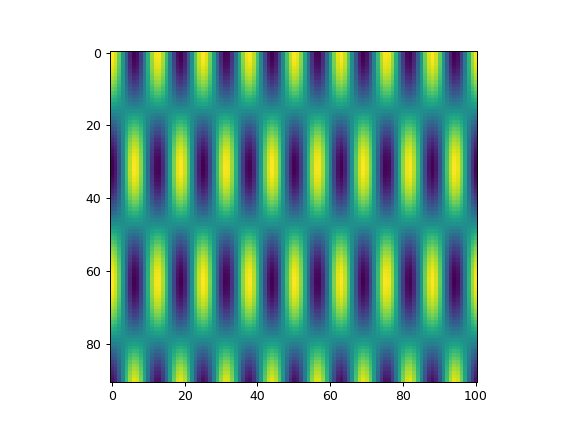

In [25]:
fig, ax = plt.subplots(1,1)
ax.imshow(zdata.T)